In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
from statistics import mode
import tensorflow as tf
import tensorflow_datasets as tfds
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
logger = tf.get_logger()
logger.propagate = False

In [3]:
train = pd.read_csv("data/titanic/train.csv")
test = pd.read_csv("data/titanic/test.csv")
gender_submission = pd.read_csv("data/titanic/gender_submission.csv")

#### 데이터 확인

In [4]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

#### 데이터 결측치 확인

- Age, Cabin, Embarked 결측치 발견

In [7]:
train.isnull().mean(axis=0)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Text(0.5, 1.0, 'Null Values in Training Set')

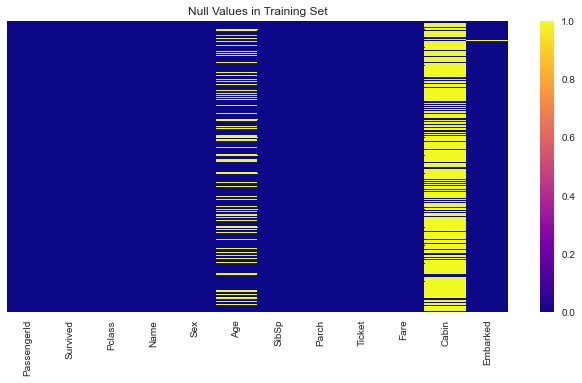

In [8]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), yticklabels = False, cmap='plasma')
plt.title('Null Values in Training Set')

- 결측치 채우기
    1. Embarked : 최빈값으로 채우기
    2. Fare: 중앙값으로 채우기
    3. Cabin: NaN -> U(nknown)

In [9]:
train.loc[train.Age.isnull(), 'Age'] = train.groupby("Pclass").Age.transform('median')
test.loc[test.Age.isnull(), 'Age'] = test.groupby("Pclass").Age.transform('median')
train['Embarked'] = train['Embarked'].fillna(mode(train['Embarked']))
test['Embarked'] = test['Embarked'].fillna(mode(test['Embarked']))
train['Fare']  = train.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
test['Fare']  = test.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
train['Cabin'] = train['Cabin'].fillna('U')
test['Cabin'] = test['Cabin'].fillna('U')

# 변수 전처리

#### Sex 변환

In [10]:
train['Sex'][train['Sex'] == 'male'] = 0
train['Sex'][train['Sex'] == 'female'] = 1

test['Sex'][test['Sex'] == 'male'] = 0
test['Sex'][test['Sex'] == 'female'] = 1

train['Sex'] = train['Sex'].astype(int)
test['Sex'] = test['Sex'].astype(int)

#### Embarked ont hot encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
temp = pd.DataFrame(encoder.fit_transform(train[['Embarked']]).toarray(), columns=['S', 'C', 'Q'])
train = train.join(temp)
# train.drop(columns='Embarked', inplace=True)

temp = pd.DataFrame(encoder.transform(test[['Embarked']]).toarray(), columns=['S', 'C', 'Q'])
test = test.join(temp)
# test.drop(columns='Embarked', inplace=True)

#### Cabin 등급으로 분류

In [12]:
train['Cabin'] = train['Cabin'].map(lambda x:re.compile("([a-zA-Z])").search(x).group())
test['Cabin'] = test['Cabin'].map(lambda x:re.compile("([a-zA-Z])").search(x).group())

In [13]:
cabin_category = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':9}
train['Cabin'] = train['Cabin'].map(cabin_category)
test['Cabin'] = test['Cabin'].map(cabin_category)

#### Name 필요 변수 추출

In [14]:
train['Name'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
test['Name'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

In [15]:
train.rename(columns={'Name' : 'Title'}, inplace=True)
train['Title'] = train['Title'].replace(['Rev', 'Dr', 'Col', 'Ms', 'Mlle', 'Major', 'Countess', 
                                       'Capt', 'Dona', 'Jonkheer', 'Lady', 'Sir', 'Mme', 'Don'], 'Other')
                                      
test.rename(columns={'Name' : 'Title'}, inplace=True)
test['Title'] = test['Title'].replace(['Rev', 'Dr', 'Col', 'Ms', 'Mlle', 'Major', 'Countess', 
                                       'Capt', 'Dona', 'Jonkheer', 'Lady', 'Sir', 'Mme', 'Don'], 'Other')

encoder = OneHotEncoder()
temp = pd.DataFrame(encoder.fit_transform(train[['Title']]).toarray())
train = train.join(temp)
# train.drop(columns='Title', inplace=True)

temp = pd.DataFrame(encoder.transform(test[['Title']]).toarray())
test = test.join(temp)
# test.drop(columns='Title', inplace=True)

#### SibSp / Parch  전처리

In [16]:
train['familySize'] = train['SibSp'] + train['Parch'] + 1
test['familySize'] = test['SibSp'] + test['Parch'] + 1

In [17]:
train['isAlone'] = 0 
test['isAlone'] =  0 
train.loc[train['familySize'] > 1, 'isAlone'] = 0 
test.loc[test['familySize'] > 1, 'isAlone'] = 0 

#### Fare 등급

In [18]:
train['FareBin'] = pd.qcut(train['Fare'], 4, duplicates='drop', labels=False)
test['FareBin'] = pd.qcut(test['Fare'], 4, duplicates='drop', labels=False)

#### 나이 등급

In [19]:
train['AgeBin'] = pd.cut(train['Age'], 4, duplicates='drop', labels = False)
test['AgeBin'] = pd.cut(test['Age'], 4, duplicates='drop', labels = False)

#### 데이터

In [20]:
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

train.head()

PassengerId  Survived  Pclass Title  Sex   Age  SibSp  Parch  \
0            1         0       3    Mr    0  22.0      1      0   
1            2         1       1   Mrs    1  38.0      1      0   
2            3         1       3  Miss    1  26.0      0      0   
3            4         1       1   Mrs    1  35.0      1      0   
4            5         0       3    Mr    0  35.0      0      0   

             Ticket     Fare  ...    Q    0    1    2    3    4  familySize  \
0         A/5 21171   7.2500  ...  1.0  0.0  0.0  1.0  0.0  0.0           2   
1          PC 17599  71.2833  ...  0.0  0.0  0.0  0.0  1.0  0.0           2   
2  STON/O2. 3101282   7.9250  ...  1.0  0.0  1.0  0.0  0.0  0.0           1   
3            113803  53.1000  ...  1.0  0.0  0.0  0.0  1.0  0.0           2   
4            373450   8.0500  ...  1.0  0.0  0.0  1.0  0.0  0.0           1   

   isAlone  FareBin  AgeBin  
0        0        0       1  
1        0        3       1  
2        0        1       1  
3        0        3       1  
4        0        1       1  

[5 rows x 24 columns]

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Title        891 non-null    object 
 4   Sex          891 non-null    int32  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    int64  
 11  Embarked     891 non-null    object 
 12  S            891 non-null    float64
 13  C            891 non-null    float64
 14  Q            891 non-null    float64
 15  0            891 non-null    float64
 16  1            891 non-null    float64
 17  2            891 non-null    float64
 18  3            891 non-null    float64
 19  4       

# 모델

In [ ]:
output_col = 'Survived'
input_col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'S', 'C', 'Q', '0', '1', '2', '3', '4', 'familySize', 'FareBin', 'AgeBin', 'isAlone']


In [ ]:
def feature_label_set(df, input_col, output_col):
    return df[input_col], df[output_col]

def input_fn(features, labels, training=True, batch_size=256):
    if type(labels) != type(None):
        dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
        if training:
            dataset = dataset.shuffle(1000).repeat()    
        return dataset.batch(batch_size)
    else:
        return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)
        
def input_feature_columns(data):
    feature_columns = []
    for key in data.keys():
        feature_columns.append(tf.feature_column.numeric_column(key=key))
    return feature_columns

### 1. 입력
- 입력 함수
    - feature / label을 제공하는 기능
    - 함수 외의 방법으로 사용 가능
- 입력 파이프라인
    - tensorflow Dataset API
    - pandas DataFrame에서 변형가능
    - 배치 등 편의기능이 있음
- 입력 feature engineering
    - tf.feature_column
    - 데이터를 범주형/연속형 등으로 변환하는 함수
    - https://excelsior-cjh.tistory.com/175

### 2. 모델 인스턴스화

#### 1. 사전 제작 된 Estimator: Linear
1. 사전 제작 된 모델 Estimator 인스턴스화
2. 학습
3. 평가/예측

In [ ]:
features, labels = feature_label_set(train, input_col, output_col)

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=input_feature_columns(train[input_col]))
linear_est.train(input_fn=lambda: input_fn(features, labels, training=True, batch_size=64), steps=5000)
result = linear_est.evaluate(input_fn=lambda: input_fn(test[input_col], gender_submission[output_col], False))

In [ ]:
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**result))

In [ ]:
predictions = linear_est.predict(input_fn=lambda: input_fn(test[input_col], None, False))
for pred_dict, expec in zip(predictions, gender_submission[output_col]):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]    
    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(class_id, 100 * probability, expec))

#### 2. 사전 제작 된 Estimator
1. 사전 제작 된 모델 Estimator 인스턴스화
2. 학습
3. 평가/예측

In [ ]:
features, labels = feature_label_set(train, input_col, output_col)

In [ ]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=input_feature_columns(train[input_col]),
    hidden_units=[16],
    n_classes=2)

classifier.train(input_fn=lambda: input_fn(features, labels, training=True, batch_size=64), steps=5000)

In [ ]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test[input_col], gender_submission[output_col], False))

In [ ]:
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [ ]:
predictions = classifier.predict(input_fn=lambda: input_fn(test[input_col], None, False)) 

In [ ]:
for pred_dict, expec in zip(predictions, gender_submission[output_col]):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]    
    print('Prediction is "{}" ({:.1f}%), expected "{}"'.format(class_id, 100 * probability, expec))


#### 2. 커스텀 Estimator 
1. 커스텀 모델 생성
2. 모델 Estimator 인스턴트화
3. 학습
4. 평가/예측

In [ ]:
def input_fn(features, labels):
    dataset = tf.data.Dataset.from_tensor_slices((features.values, labels.values))
    dataset = dataset.map(lambda features, labels: ({'input':features}, labels))
    dataset = dataset.batch(32).repeat()
    return dataset

In [ ]:
output_col = 'Survived'
input_col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'S', 'C', 'Q', '0', '1', '2', '3', '4', 'familySize', 'FareBin', 'AgeBin', 'isAlone']

In [ ]:
features, labels = input_evaluation_set(train, input_col, output_col)

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(19,), name='input'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax', name='output'),
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
import tempfile
tempfile.mkdtemp()

model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir=model_dir)
keras_estimator.train(input_fn = lambda: input_fn(features, labels), steps=10000)
eval_result = keras_estimator.evaluate(input_fn=lambda: input_fn(test[input_col], gender_submission[output_col]), steps=10)

In [ ]:
print('평가 결과: {}'.format(eval_result))

In [ ]:
def input_fn(features):
    return tf.data.Dataset.from_tensor_slices((features.values)).batch(32)

In [ ]:
predictions = keras_estimator.predict(input_fn=lambda: input_fn(test[input_col])) 

preds = []
for pred_dict, expec in zip(predictions, gender_submission[output_col]):
    pred = pred_dict['output'].argmax()
    print([pred_dict['output'], pred, expec])
    preds.append(pred)

#### 3. with Categorical variables

In [23]:
# Title_dict = {i:n+1 for n,i in enumerate(train['Title'].unique())}
# Cabin_dict = {i:n+1 for n,i in enumerate(train['Cabin'].unique())}

# train['Cabin_category'] = train['Cabin'].map(Cabin_dict)
# train['Title_category'] = train['Title'].map(Title_dict)

# test['Cabin_category'] = test['Cabin'].map(Cabin_dict)
# test['Title_category'] = test['Title'].map(Title_dict)

In [27]:
output_col = 'Survived'
cate_col = ['Pclass', 'Sex', 'familySize', 'FareBin', 'AgeBin', 'isAlone']
cont_col = ['Age', 'SibSp', 'Parch', 'Fare', 'familySize']

In [47]:
train['category'] = train[cate_col].apply(lambda x: "".join([str(i) for i in x.values]), axis=1)
cate_dict = {i:n+1 for n, i in enumerate(train['category'].unique())}
train['category'] = train['category'].map(cate_dict)

In [49]:
# Define the embedding input
cate_input = tf.keras.layers.Input(shape=(1,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
embeddings_output = 10

# Let’s define the embedding layer and flatten it
cate_embedings = tf.keras.layers.Embedding(output_dim=embeddings_output, input_dim=len(cate_dict), input_length=1)(cate_input)
cate_embedings = tf.keras.layers.Reshape((embeddings_output,))(cate_embedings)

In [53]:
# Define the continuous variables input (just like before)
continuous_input = tf.keras.layers.Input(shape=(train[cont_col].shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = tf.keras.layers.concatenate([continuous_input, cate_embedings])

In [57]:
# Define the model
units=25
dense1 = tf.keras.layers.Dense(units=units, activation='relu')(all_input)
dense2 = tf.keras.layers.Dense(units, activation='relu')(dense1)
predictions = tf.keras.layers.Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = tf.keras.models.Model(inputs=['Age', 'SibSp', 'Parch', 'Fare', 'familySize','category'], outputs=predictions)

ValueError: Input tensors to a Functional must come from `tf.keras.Input`. Received: Age (missing previous layer metadata).

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(19,), name='input'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax', name='output'),
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)